In [1]:
# data stuff:
import pandas as pd
import numpy as np

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
from IPython.core.display import display, HTML
from dtreeviz.trees import dtreeviz
import graphviz
import pydotplus

# stats stuff:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# modeling stuff:
import optuna
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## 📊 Conversion Analysis:
Below we cover:

* Decision Trees for Conversion Analysis





**📄 Dataset:** UCI Bank Marketing Data Set (https://archive.ics.uci.edu/ml/datasets/bank+marketing)

📚 See chapter 4 of _"Data Science for Marketing"_ by Hwang, page 112.

---

### Import data and preprocess:

In [2]:
# read file:
pd.set_option("display.max_columns", None)
data = pd.read_csv('data/bank-full.csv', sep=';')

# encode conversion column:
data['conversion'] = data['y'].apply(lambda x: 1 if x=='yes' else 0)
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,conversion
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no,0


&nbsp;

#### Set Numerical Features:
We don't need to preprocess thesse, as they are already in numerical format. We'll create a subset df of them and use them later.

In [3]:
numericals = data[['age', 'balance', 'campaign', 'previous']]

&nbsp;

#### Preprocess Categorical Features:

In [4]:
# encode 'housing':
housing_df = pd.get_dummies(data['housing'], drop_first=True, prefix='housing')

In [5]:
# encode 'marital':
marital_df = pd.get_dummies(data['marital'], drop_first=True, prefix='marital')

In [6]:
# encode 'job':
job_df = pd.get_dummies(data['job'], drop_first=True, prefix='job')

In [7]:
# encode 'education':
education_df = pd.get_dummies(data['education'], drop_first=True, prefix='education')

In [8]:
# gather all categorical dfs into a single df:
categoricals = housing_df.join([marital_df, job_df])
categoricals

,housing_yes,marital_married,marital_single,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0,1,0,0,0,0,0,0,0,0,0,1,0,0
45207,0,0,0,0,0,0,0,1,0,0,0,0,0,0
45208,0,1,0,0,0,0,0,1,0,0,0,0,0,0
45209,0,1,0,1,0,0,0,0,0,0,0,0,0,0


&nbsp;

#### Set Predictors and Target Variables:

In [9]:
target = data['conversion']
predictors = numericals.join(categoricals)

&nbsp;

---
### Initialize Decision Tree Model:
Let's build some decision tree models so we can see which factors drive engagement.

&nbsp;

#### Find optimal parameters with Optuna (Decision Tree search only)
Below we find the optimal parameters for a decision tree model using bayesian optimization.

In [10]:
def optuna_dt(trial):
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 50)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.001, 0.5)
    max_features = trial.suggest_categorical('max_features', [1, 'auto', 'sqrt', 'log2'])
    
    test_model = tree.DecisionTreeClassifier(max_depth=max_depth,
                                             min_samples_split=min_samples_split, 
                                             min_samples_leaf=min_samples_leaf,
                                             min_weight_fraction_leaf=min_weight_fraction_leaf,
                                             max_features=max_features
                                            )

    val_score = np.mean(cross_val_score(test_model, predictors, target, cv=10))
    return val_score

# find optimal params (orders) that will maximize accuracy:
study=optuna.create_study(direction="maximize")
study.optimize(optuna_dt, n_trials=10)

[I 2022-06-14 13:32:04,163] A new study created in memory with name: no-name-fa610afd-7868-4978-9fbf-2d7987351ef2
[I 2022-06-14 13:32:04,255] Trial 0 finished with value: 0.8830151953911869 and parameters: {'max_depth': 3, 'min_samples_split': 27, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.41714638033946183, 'max_features': 1}. Best is trial 0 with value: 0.8830151953911869.
[I 2022-06-14 13:32:04,382] Trial 1 finished with value: 0.8830151953911869 and parameters: {'max_depth': 3, 'min_samples_split': 25, 'min_samples_leaf': 35, 'min_weight_fraction_leaf': 0.021974336403110035, 'max_features': 'log2'}. Best is trial 0 with value: 0.8830151953911869.
[I 2022-06-14 13:32:04,475] Trial 2 finished with value: 0.8830151953911869 and parameters: {'max_depth': 5, 'min_samples_split': 40, 'min_samples_leaf': 23, 'min_weight_fraction_leaf': 0.49808815875544427, 'max_features': 'log2'}. Best is trial 0 with value: 0.8830151953911869.
[I 2022-06-14 13:32:04,570] Trial 3 finished with 

&nbsp;

#### Find optimal parameters with Optuna (XGboost and Decision Tree search)
Below we find the optimal parameters for both XGB and Decision Tree models.

In [11]:
# def best_model(trial):
#     # define model types
#     model_type = trial.suggest_categorical('model_type', ['XGB', 'DecisionTree'])
    
#     # suggest DT params and build:
#     if model_type=='DecisionTree':
#         max_depth = trial.suggest_int('max_depth', 2, 10)
#         min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
#         min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 50)
#         min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.001, 0.5)
#         max_features = trial.suggest_categorical('max_features', [1, 'auto', 'sqrt', 'log2'])
        
#         # initialize model with trial vals:
#         test_model = tree.DecisionTreeClassifier(max_depth=max_depth,
#                                                  min_samples_split=min_samples_split, 
#                                                  min_samples_leaf=min_samples_leaf,
#                                                  min_weight_fraction_leaf=min_weight_fraction_leaf,
#                                                  max_features=max_features)
#     # suggest XGB params and build:
#     elif model_type=='XGB':
#         # xgb params:
#         learning_rate=trial.suggest_float("learning_rate", 0.01, 1, step=0.01)
#         max_depth=trial.suggest_int('max_depth', 1, 50, step=1)
#         n_estimators=trial.suggest_int('n_estimators', 1, 1000, step=10)
#         subsample=trial.suggest_float("subsample", 0.01, 1, step=0.01)
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1, step=0.01)
#         reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1, step=0.01)
#         reg_lambda=trial.suggest_float("reg_lambda", 0.0, 1, step=0.01)
#         gamma=trial.suggest_float("gamma", 0.0, 1, step=0.01)
#         eval_metric='logloss'

#         # set params with trial vals:
#         params = {'learning_rate': learning_rate,
#                   'max_depth': max_depth,
#                   'n_estimators': n_estimators,
#                   'subsample': subsample, 
#                   'colsample_bytree': colsample_bytree,
#                   'reg_alpha': reg_alpha,
#                   'reg_lambda': reg_lambda,
#                   'gamma': gamma,
#                   'eval_metric':eval_metric
#                  }
    
#         # initialize:
#         test_model=XGBClassifier().set_params(**params)
    
#     # evaluate the model using cross-validation:
#     val_score = np.mean(cross_val_score(test_model, predictors, target, cv=10))
#     return val_score

# # find optimal params (orders) that will maximize accuracy:
# study=optuna.create_study(direction="maximize")
# study.optimize(best_model, n_trials=10)

&nbsp;

In [12]:
# # optimal result and corresponding params:
# trial_cv=study.best_trial

# # top r-squared value:
# trial_value_cv = np.round(trial_cv.value, 3)

# print(f"Validation Score: {trial_value_cv}")
# print("best params for decision Tree: {}".format(trial_cv.params))


&nbsp;

#### Build and Evaluate best Tree Model:

Test accuracy = 0.8812341037266394


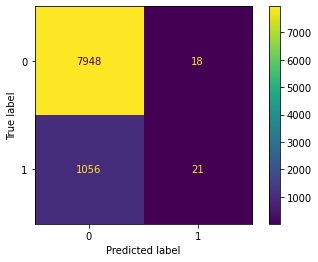

In [21]:
# split:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2)

# params:
best_params = {'max_depth': 4}

# fit model on training data
test_model = tree.DecisionTreeClassifier().set_params(**best_params)
test_model.fit(X_train, y_train)

# tree preds and accuracy:
preds_dt = test_model.predict(X_test)
print(f'Test accuracy = {accuracy_score(y_test, preds_dt)}')
plot_confusion_matrix(test_model, X_test, y_test);

&nbsp;

---
### Plot Decision Tree:

In [22]:
# define decision tree data model and params:
dot_data = tree.export_graphviz(
    test_model, 
    out_file=None, 
    feature_names=predictors.columns,  
    class_names=['non-conversion', 'conversion'],  
    filled=True, 
    rounded=False,
    # rotate=True,
    special_characters=True
) 

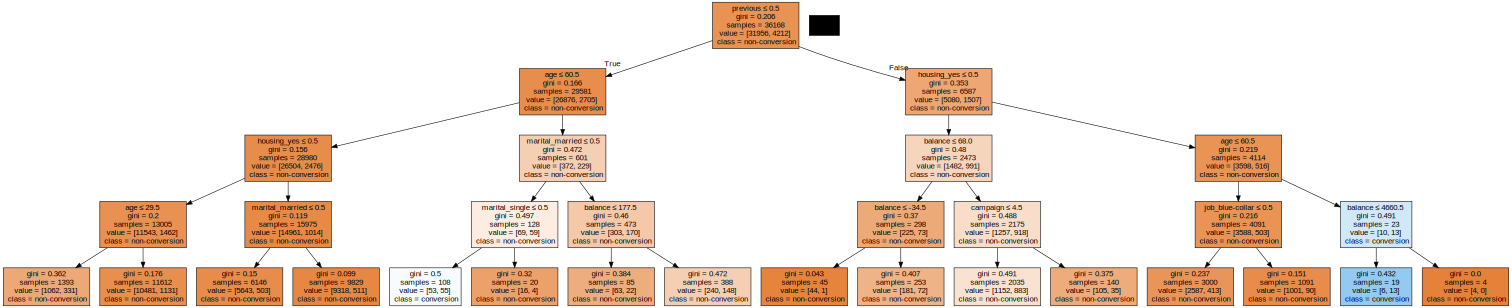

In [23]:
# set graph size and display:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"21,21!"')

# graph
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

&nbsp;

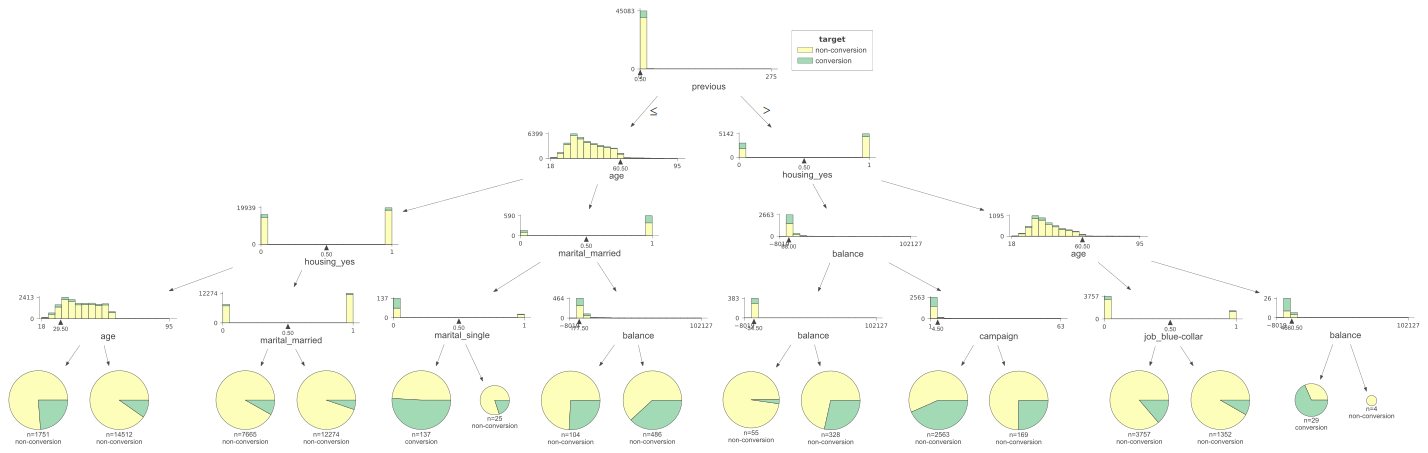

In [24]:
# alternative visualization:
viz = dtreeviz(test_model, predictors, target,
               target_name="target",
               feature_names=predictors.columns,
               class_names=['non-conversion', 'conversion']
              )

viz

&nbsp;

#### Visualize Decision Path for single record:

##### Full path:

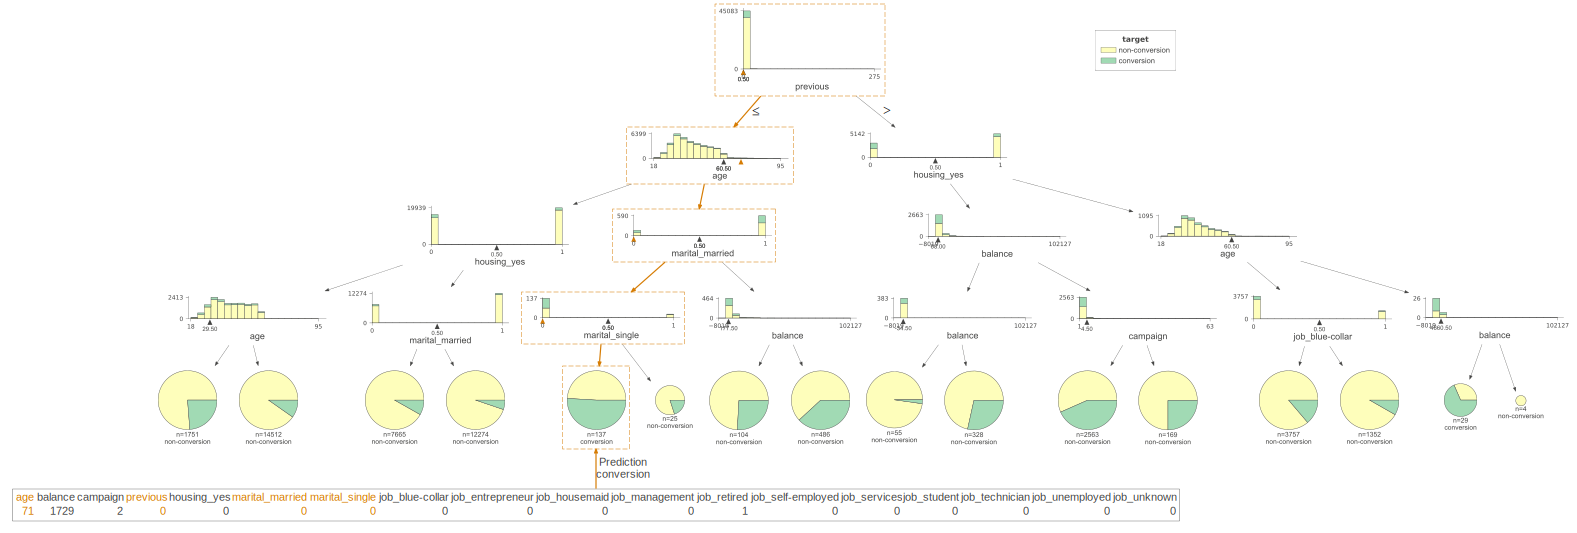

In [25]:
# alternative visualization:
viz = dtreeviz(test_model, predictors, target,
               target_name="target",
               feature_names=predictors.columns,
               class_names=['non-conversion', 'conversion'],
               X=predictors.iloc[45207],
               # show_just_path=True,
               # orientation ='LR'
              )

viz

##### Single Path:

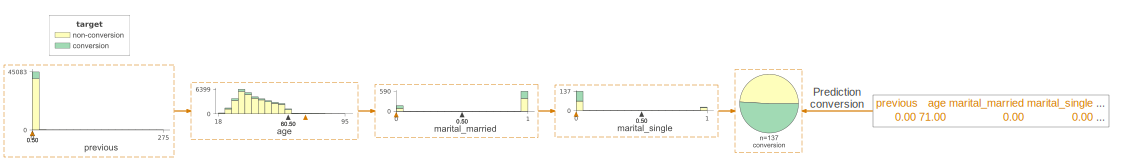

In [27]:
# alternative visualization:
viz = dtreeviz(test_model, predictors, target,
               target_name="target",
               feature_names=predictors.columns,
               class_names=['non-conversion', 'conversion'],
               X=predictors.iloc[45207],
               show_just_path=True,
               orientation ='LR'
              )

viz

&nbsp;

---
### Decision Tree Prediction Output Analysis:

The plot above can be read as follows:

* previous = 0 ---> this customer hasn't been contacted before, i.e. has not been targeted by a marketing campaign
* age = 71 ---> age of the individual
* marital_married = 0 ---> this individual is not married
* marital_single = 0 ---> this individual is not single
* the two categories above equaling zero, means this individual is 'divorced' (we one-hot-encoded the variables and dropped one redundant category to avoid multicollinearity issues)

That's the path one must traverse through the tree to arrive at 'conversion'. Thus, if we want to target individuals susceptible to 'conversion', then we might be looking at older people, who haven't been contacted before, and who are single.